In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
torch.manual_seed(42)

## Cabinet Data
#### The General Dataset (World)

In [2]:
from re import X
from google.colab import drive
drive.mount('/content/drive')

# Parameters
device = torch.device("cuda")
batch_size_world = 2048

X_path = '/content/drive/MyDrive/DiffusionModel/Self-Generated Data training/X.npy'
Y_path = '/content/drive/MyDrive/DiffusionModel/Self-Generated Data training/Y.npy'

# Load the global data for training
X_world = np.load(X_path)
Y_world = np.load(Y_path)

# Create the Dataloader for the general data
Data_world = np.hstack((Y_world, X_world))
data_world_tensor = torch.tensor(Data_world, dtype=torch.float32).to(device)
dataset_world = TensorDataset(data_world_tensor)
data_world_loader = DataLoader(dataset_world, batch_size=batch_size_world, shuffle=True)

print("Shape for world data: " + str(Data_world.shape))

Mounted at /content/drive
Shape for world data: (55398, 6)


The specialized dataset (House)

In [3]:
# Cabinets were in [(-5, -5, 0), (5, 5, 2)]
# plates were in [(cab_x - 1, cab_y - 1, cab_z), (cab_x + 1, cab_y + 1, cab_z + 1)].
house_num_points = 128
batch_size_house = 64

# Information from World Dataset
# x_range = (-5, 5)
# y_range = (-5, 5)
# z_range = (0, 2)

# Generate the data we want to specialize our model on
np.random.seed(42)
X_house = np.column_stack((
    np.random.uniform(-5, 5, house_num_points),
    np.random.uniform(-5, 5, house_num_points),
    np.random.uniform(0, 2, house_num_points)
))

Y_house = np.zeros((house_num_points, 3))
for i in range(house_num_points):
    Y_house[i] = [
        np.random.uniform(X_house[i, 0] - 1, X_house[i, 0]), # I used different conditions than the world data
        np.random.uniform(X_house[i, 1] - 1, X_house[i, 1]), # Also different conditions for y-axis
        np.random.uniform(X_house[i, 2], X_house[i, 2] + 0.5) # different conditions for z-axis
    ]

Data_house = np.hstack((Y_house, X_house))
data_house_tensor = torch.tensor(Data_house, dtype=torch.float32).to(device)
dataset_house = TensorDataset(data_house_tensor)
data_house_loader = DataLoader(dataset_house, batch_size=batch_size_house, shuffle=True)

print("Shape for house data: " + str(Data_house.shape))

Shape for house data: (128, 6)


Data Distribution Visualization

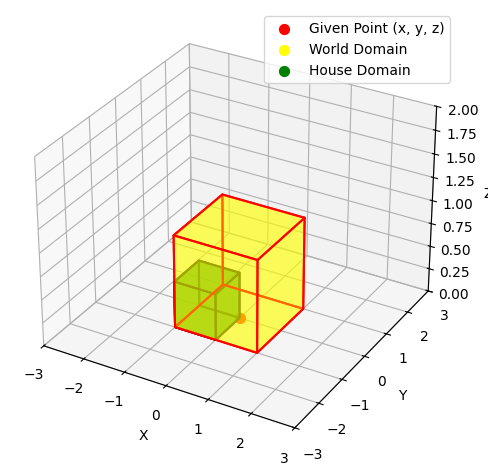

In [4]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


def draw_cuboid(ax, corner, size, face_color, edge_color, label=None, alpha=0.3):
    x, y, z = corner
    dx, dy, dz = size
    vertices = np.array([[x, y, z],
                         [x + dx, y, z],
                         [x + dx, y + dy, z],
                         [x, y + dy, z],
                         [x, y, z + dz],
                         [x + dx, y, z + dz],
                         [x + dx, y + dy, z + dz],
                         [x, y + dy, z + dz]])

    faces = [[vertices[j] for j in [0, 1, 2, 3]],
             [vertices[j] for j in [4, 5, 6, 7]],
             [vertices[j] for j in [0, 1, 5, 4]],
             [vertices[j] for j in [2, 3, 7, 6]],
             [vertices[j] for j in [1, 2, 6, 5]],
             [vertices[j] for j in [4, 7, 3, 0]]]

    poly = Poly3DCollection(faces, facecolors=face_color, edgecolors=edge_color, linewidths=1.5, alpha=alpha)
    ax.add_collection3d(poly)
    if label:
        ax.text(x + dx/2, y + dy/2, z + dz + 0.05, label, color=edge_color, ha='center')

# Create the figure
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')

# Reference point at origin
ax.scatter(0, 0, 0, color='red', s=50, label='Given Point (x, y, z)')
ax.scatter(1000, 1000, 1000, color='yellow', s = 50, label = 'World Domain')
ax.scatter(1000, 1000, 1000, color='green', s = 50, label = 'House Domain')

# Cabinet range: from (-1, -1, 0) to (1, 1, 1)
draw_cuboid(ax, corner=(-1, -1, 0), size=(2, 2, 1), face_color='yellow', edge_color='red', alpha=0.4)

# Second cabinet range: (-1, -1, 0) to (0, 0, 0.5)
draw_cuboid(ax, corner=(-1, -1, 0), size=(1, 1, 0.5), face_color='green', edge_color='black', alpha=0.5)

# Set axes
ax.set_xlim([-3, 3])
ax.set_ylim([-3, 3])
ax.set_zlim([0, 2])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()

plt.savefig("cabinetcondition.pdf", bbox_inches='tight')
plt.tight_layout()
plt.show()

## Define the Diffusion Model

In [5]:
# Model Defined
class DiffusionBlock(nn.Module):
    def __init__(self, nunits):
        super(DiffusionBlock, self).__init__()
        self.linear = nn.Linear(nunits, nunits)

    def forward(self, x: torch.Tensor):
        x = self.linear(x)
        x = nn.functional.relu(x)
        return x

class DiffusionModel(nn.Module):
    def __init__(self, xfeatures: int, yfeatures: int, nblocks: int = 2, nunits: int = 64):
        super(DiffusionModel, self).__init__()
        self.inblock = nn.Linear(xfeatures + yfeatures + 1, nunits)
        self.midblocks = nn.ModuleList([DiffusionBlock(nunits) for _ in range(nblocks)])
        self.outblock = nn.Linear(nunits, yfeatures)

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:

        val = torch.hstack([x,  t.type(torch.float32)])
        val = self.inblock(val)
        for midblock in self.midblocks:
            val = midblock(val)
        val = self.outblock(val)
        return val


def noise(Xbatch, t, baralphas, yfeatures):
    # Edited so that it does not give the device error
    Xbatch = Xbatch.to(device)
    Xbatch_temp = Xbatch[:, 0:yfeatures]
    baralphas = baralphas.to(device)
    # noise function
    eps = torch.randn_like(Xbatch_temp)
    noised = (baralphas[t] ** 0.5).view(-1, 1) * Xbatch_temp + ((1 - baralphas[t]) ** 0.5).view(-1, 1) * eps
    noised = torch.hstack([noised, Xbatch[:, yfeatures:]])
    return noised, eps

### Noising Parameters

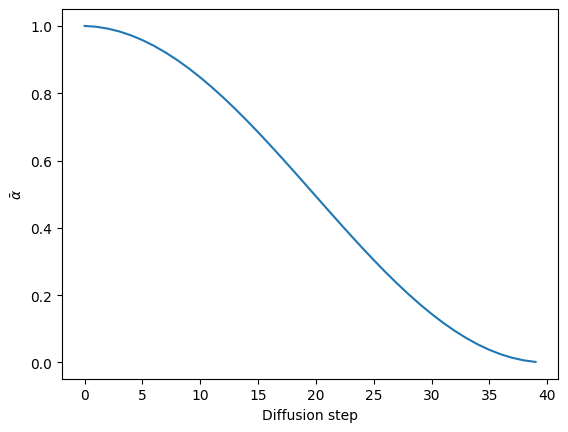

In [6]:
# Define parameters
nepochs = 100

diffusion_steps = 40
s = 0.008
timesteps = torch.tensor(range(0, diffusion_steps), dtype=torch.float32)
schedule = torch.cos((timesteps / diffusion_steps + s) / (1 + s) * np.pi / 2) ** 2

baralphas = schedule / schedule[0]
betas = 1 - baralphas / torch.cat([baralphas[:1], baralphas[:-1]])
alphas = 1 - betas

sns.lineplot(baralphas)
plt.xlabel("Diffusion step")
plt.ylabel(r"$\bar{\alpha}$")
plt.show()

### Training Algorithm

In [7]:
# Initialize
loss_fn = nn.MSELoss()

def train_model(model, data_loader, loss_fn, nepochs, loss_values,
                diffusion_steps, baralphas, device, batch_size, yfeatures):

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

    model.train()

    for epoch in range(nepochs):
        epoch_loss = 0
        for batch in data_loader:
            Xbatch = batch[0].to(device)
            Xbatch = Xbatch.type(torch.float32)

            timesteps = torch.randint(0, diffusion_steps, (len(Xbatch),), dtype=torch.long).to(device)
            noised, eps = noise(Xbatch, timesteps, baralphas, yfeatures)

            predicted_noise = model(noised, timesteps.unsqueeze(-1).type(torch.float32))

            loss = loss_fn(predicted_noise, eps)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(data_loader)
        loss_values.append(avg_loss)

        scheduler.step()  # Update scheduler after each epoch

    return loss_values


### Generate Samples Algorithm

In [8]:
def sample_generate(model, nsamples, X, yfeatures):
    """
    Vectorized sampler for DDPM.

    Args:
        model: The diffusion model.
        nsamples: Number of samples per input coordinate.
        X: Tensor of coordinates, shape (N, 3), where N is the number of coordinate inputs.
        yfeatures: Dimensionality of the target features to sample.

    Returns:
        Y_final: Final denoised outputs, shape (nsamples, N, yfeatures).
        Y_all_steps: List of outputs at each timestep, each of shape (nsamples, N, yfeatures).
    """
    N = X.shape[0]
    device = X.device

    # Expand coordinates: (1, N, 3) -> (nsamples, N, 3) -> (nsamples * N, 3)
    X_coords = X.view(1, N, 3).repeat(nsamples, 1, 1)
    X_coords = X_coords.view(-1, 3)

    # Initial noise sample: (nsamples * N, yfeatures)
    Y = torch.randn(nsamples * N, yfeatures).to(device)

    # Combine with coordinates: (nsamples * N, yfeatures + 3)
    Y_comb = torch.hstack((Y, X_coords))

    Y_all_steps = [Y.view(nsamples, N, yfeatures)]

    with torch.no_grad():
        for t in range(diffusion_steps - 1, 0, -1):
            t_tensor = torch.full((nsamples * N, 1), t, dtype=torch.long, device=device)

            pred_noise = model(Y_comb, t_tensor)

            alpha = alphas[t]
            baralpha = baralphas[t]
            beta = betas[t]

            Y = (1 / alpha**0.5) * (Y - ((1 - alpha) / (1 - baralpha)**0.5) * pred_noise)

            if t > 1:
                noise = torch.randn_like(Y)
                Y += (beta**0.5) * noise

            Y_comb = torch.hstack((Y, X_coords))
            Y_all_steps.append(Y.view(nsamples, N, yfeatures))

    Y_final = Y.view(nsamples, N, yfeatures)
    return Y_final, Y_all_steps


def sample_joint_generate(model1, model2, nsamples, X, yfeatures):
    """
    Vectorized sampler that combines two models in a joint diffusion process.

    Args:
        model1: The first diffusion model.
        model2: The second diffusion model.
        nsamples: Number of samples per coordinate in X.
        X: Tensor of coordinates, shape (N, 3) where N is the number of inputs.
        yfeatures: Dimensionality of the target features to sample.

    Returns:
        Y_final: Final denoised outputs, shape (nsamples, N, yfeatures).
        Y_all_steps: List of outputs at each diffusion timestep, each of shape (nsamples, N, yfeatures).

    Note:
        Assumes that global variables diffusion_steps, alphas, baralphas, and betas are defined.
    """
    N = X.shape[0]
    device = X.device

    # Expand coordinates: (1, N, 3) -> (nsamples, N, 3) -> (nsamples * N, 3)
    X_coords = X.view(1, N, 3).repeat(nsamples, 1, 1).view(-1, 3)

    # Initial noise sample: (nsamples * N, yfeatures)
    Y = torch.randn(nsamples * N, yfeatures).to(device)

    # Combine the noise with the coordinates
    Y_comb = torch.hstack((Y, X_coords))
    Y_all_steps = [Y.view(nsamples, N, yfeatures)]

    with torch.no_grad():
        for t in range(diffusion_steps - 1, 0, -1):
            # Create timestep tensor for all samples
            t_tensor = torch.full((nsamples * N, 1), t, dtype=torch.long, device=device)

            # Get the joint noise prediction from both models
            pred_noise = model1(Y_comb, t_tensor) + model2(Y_comb, t_tensor)

            # Update the sample using the DDPM reverse process update rule
            Y = (1 / (alphas[t] ** 0.5)) * (Y - ((1 - alphas[t]) / ((1 - baralphas[t]) ** 0.5)) * pred_noise)

            # Add noise if not at the last timestep
            if t > 1:
                Y += (betas[t] ** 0.5) * torch.randn_like(Y)

            # Update the combined tensor with the new Y values and constant coordinates
            Y_comb = torch.hstack((Y, X_coords))
            Y_all_steps.append(Y.view(nsamples, N, yfeatures))

    Y_final = Y.view(nsamples, N, yfeatures)
    return Y_final, Y_all_steps

## Training

Training the world model

Model of World Data:
DiffusionModel(
  (inblock): Linear(in_features=7, out_features=64, bias=True)
  (midblocks): ModuleList(
    (0-2): 3 x DiffusionBlock(
      (linear): Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (outblock): Linear(in_features=64, out_features=3, bias=True)
)


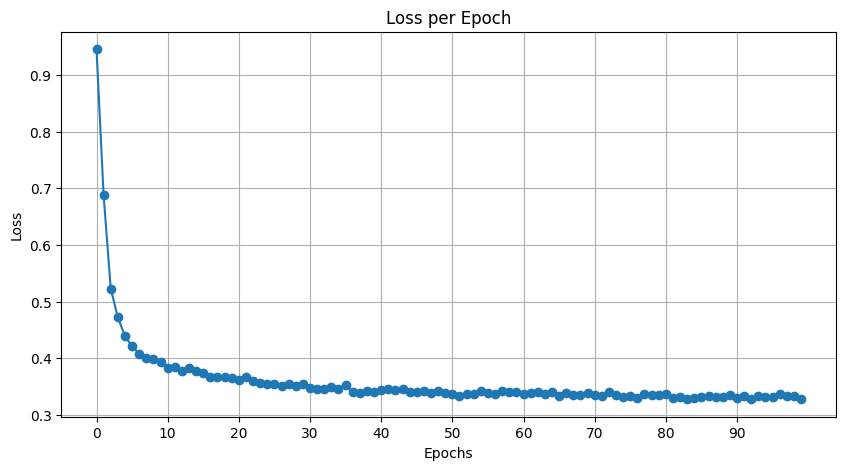

In [9]:
# Define Models
# Model trained only on the world data
model_world = DiffusionModel(xfeatures = 3, yfeatures = 3, nblocks=3)
model_world = model_world.to(device)
print("Model of World Data:")
print(model_world)
epochs = 100

loss_values_world = []
train_model(model_world, data_world_loader, loss_fn, nepochs,
            loss_values_world, diffusion_steps, baralphas, device, batch_size_world, yfeatures=3)
# Plotting the loss
plt.figure(figsize=(10, 5))
plt.plot(range(0, nepochs), loss_values_world, marker='o')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.xticks(ticks=range(0, nepochs, 10))
plt.show()

Training the House model

Model of House Data:
DiffusionModel(
  (inblock): Linear(in_features=7, out_features=64, bias=True)
  (midblocks): ModuleList(
    (0-2): 3 x DiffusionBlock(
      (linear): Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (outblock): Linear(in_features=64, out_features=3, bias=True)
)


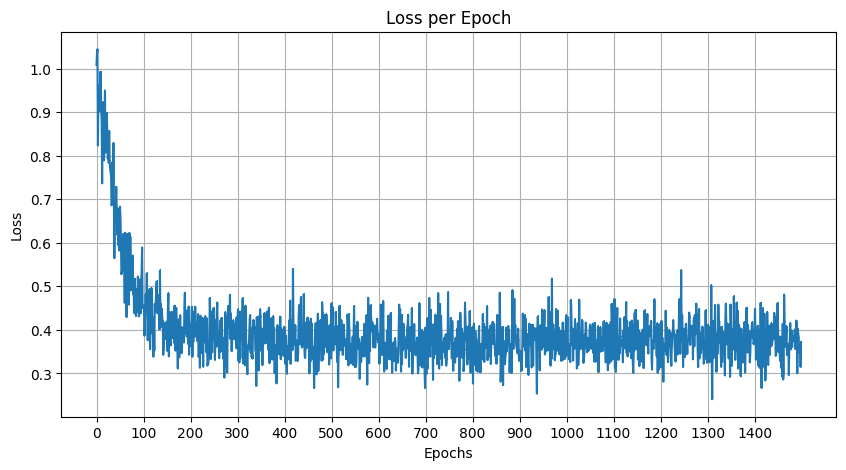

In [10]:
# Model trained only on the house data (This model is expected to be a bad model)
model_house = DiffusionModel(xfeatures = 3, yfeatures = 3, nblocks=3)
model_house = model_house.to(device)
print("Model of House Data:")
print(model_house)
nepochs_house = 1500

loss_values_house = []
train_model(model_house, data_house_loader, loss_fn, nepochs_house,
            loss_values_house, diffusion_steps, baralphas, device, batch_size_house, yfeatures=3)
# Plotting the loss
plt.figure(figsize=(10, 5))
plt.plot(range(0, nepochs_house), loss_values_house, marker=',')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.xticks(ticks=range(0, nepochs_house, 100))
plt.show()

fine-tuning model

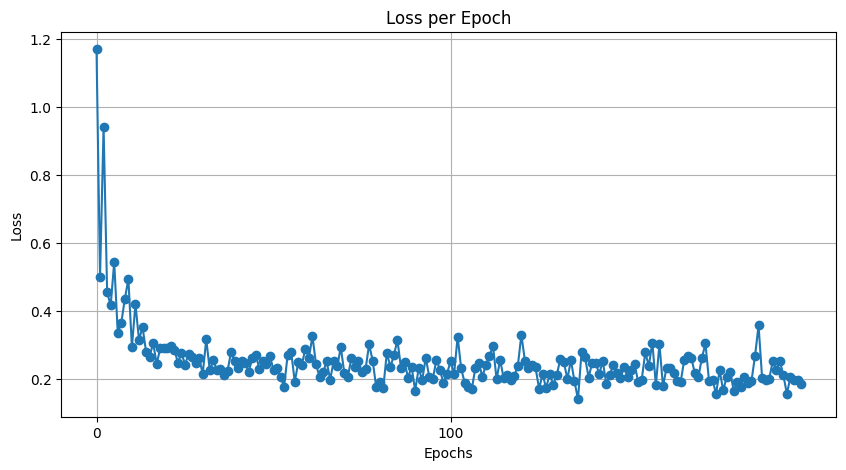

In [11]:
# Create a new model instance
model_finetune = DiffusionModel(xfeatures=3, yfeatures=3, nblocks=3)
model_finetune = model_finetune.to(device)

# Copy the trained weights from model_world
model_finetune.load_state_dict(model_world.state_dict())

# Now, fine-tune model_other on the new dataset
nepochs_finetune = 200
loss_values_finetune = []
train_model(model_finetune, data_house_loader, loss_fn, nepochs_finetune,
            loss_values_finetune, diffusion_steps, baralphas, device, batch_size_house, yfeatures=3)
# Plotting the loss
plt.figure(figsize=(10, 5))
plt.plot(range(0, nepochs_finetune), loss_values_finetune, marker='o')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.xticks(ticks=range(0, nepochs_finetune, 100))
plt.show()

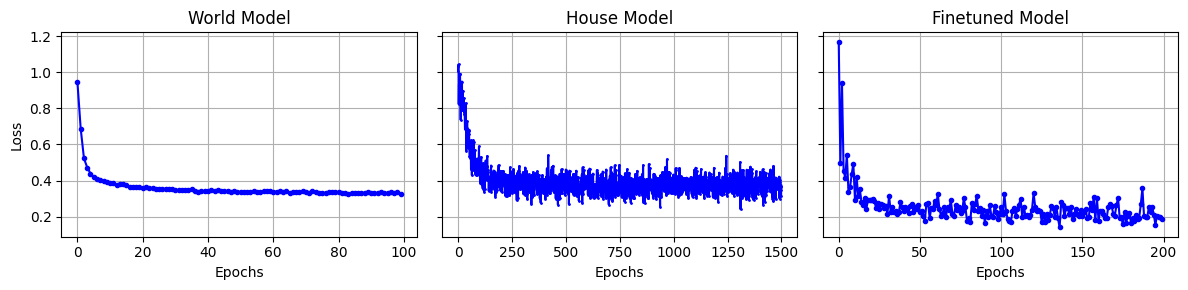

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True)

# Plot World Model Loss
axes[0].plot(range(0, epochs), loss_values_world, color='blue', marker='o', markersize=3)
axes[0].set_title('World Model')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].grid(True)

# Plot House Model Loss
axes[1].plot(range(0, nepochs_house), loss_values_house, color='blue', marker='o', markersize=1)
axes[1].set_title('House Model')
axes[1].set_xlabel('Epochs')
axes[1].grid(True)

# Plot Joint Model Loss
axes[2].plot(range(0, nepochs_finetune), loss_values_finetune, color='blue', marker='o', markersize=3)
axes[2].set_title('Finetuned Model')
axes[2].set_xlabel('Epochs')
axes[2].grid(True)

# Tight layout to avoid overlap
plt.savefig("training_cabinet.pdf", bbox_inches='tight')
plt.tight_layout()
plt.show()

## Testing and Visualization of all the results

### Cabinet: testset

In [ ]:
np.random.seed(42)
num_tests = 100000
test = np.column_stack((
    np.random.uniform(-5, 5, num_tests),
    np.random.uniform(-5, 5, num_tests),
    np.random.uniform(0, 2, num_tests)
))

test = test.astype(np.float32)

print(test.shape, test.dtype)

(100000, 3) float32


### Generating New Samples

In [ ]:
def compute_metrics(samples: np.ndarray, refs: np.ndarray):
    """
    Given:
      - samples: array of shape (S, B, 3)
      - refs:    array of shape (B, 3)

    Returns:
      - acc:     array (B,) of fraction in‑range per ref
      - avg_dist:array (B,) of avg out‑of‑range distance per ref
    """
    S, B, _ = samples.shape

    # split axes
    arr_x = samples[..., 0]
    arr_y = samples[..., 1]
    arr_z = samples[..., 2]

    # refs
    x, y, z = refs[:,0], refs[:,1], refs[:,2]
    x_low, x_high = x - 1, x
    y_low, y_high = y - 1, y
    z_low, z_high = z, z + 0.5

    # in‑range masks: shape (S,B)
    x_in = (arr_x >= x_low[None,:]) & (arr_x <= x_high[None,:])
    y_in = (arr_y >= y_low[None,:]) & (arr_y <= y_high[None,:])
    z_in = (arr_z >= z_low[None,:]) & (arr_z <= z_high[None,:])
    in_range = x_in & y_in & z_in

    # accuracy per ref
    acc = in_range.mean(axis=0)   # (B,)

    # distances
    dx = np.minimum(np.abs(arr_x - x_low[None,:]), np.abs(arr_x - x_high[None,:]))
    dy = np.minimum(np.abs(arr_y - y_low[None,:]), np.abs(arr_y - y_high[None,:]))
    dz = np.minimum(np.abs(arr_z - z_low[None,:]), np.abs(arr_z - z_high[None,:]))
    dist = np.sqrt(dx*dx + dy*dy + dz*dz)  # (S,B)

    # sum & count of out‑of‑range
    mask_out   = ~in_range
    sum_out    = (dist * mask_out).sum(axis=0)   # (B,)
    count_out  = mask_out.sum(axis=0)            # (B,)

    # safe division: only divide where count_out>0
    avg_dist = np.zeros_like(sum_out, dtype=float)
    np.divide(sum_out, count_out, out=avg_dist, where=count_out>0)

    return acc, avg_dist


def accuracy_distance_report(testset, nsamples):
    """
    Fully vectorized: no Python loops over points or coords.
    """
    # B reference coords
    refs = np.asarray(testset, dtype=np.float32)    # shape (B,3)
    B = refs.shape[0]

    coords_t = torch.tensor(refs, device=device)     # (B,3)

    # 1) World model
    samples_w, _ = sample_generate(model_world,
                                   nsamples=nsamples,
                                   X=coords_t,
                                   yfeatures=3)    # (S,B,3)
    arr_w = samples_w.cpu().numpy()
    acc_w, dist_w = compute_metrics(arr_w, refs)

    # 2) House model
    samples_h, _ = sample_generate(model_house, nsamples=nsamples,
                                   X=coords_t, yfeatures=3)
    arr_h = samples_h.cpu().numpy()
    acc_h, dist_h = compute_metrics(arr_h, refs)

    # 3) Finetuned model
    samples_f, _ = sample_generate(model_finetune, nsamples=nsamples,
                                   X=coords_t, yfeatures=3)
    arr_f = samples_f.cpu().numpy()
    acc_f, dist_f = compute_metrics(arr_f, refs)

    # 4) Joint1 (house + world)
    samples_j1, _ = sample_joint_generate(model_house, model_world,
                                          nsamples=nsamples,
                                          X=coords_t, yfeatures=3)
    arr_j1 = samples_j1.cpu().numpy()
    acc_j1, dist_j1 = compute_metrics(arr_j1, refs)

    # 5) Joint2 (finetune + world)
    samples_j2, _ = sample_joint_generate(model_finetune, model_world,
                                          nsamples=nsamples,
                                          X=coords_t, yfeatures=3)
    arr_j2 = samples_j2.cpu().numpy()
    acc_j2, dist_j2 = compute_metrics(arr_j2, refs)

    # Finally: mean across the B test points
    return (
        acc_w.mean(), acc_h.mean(), acc_j1.mean(), acc_f.mean(), acc_j2.mean(),
        dist_w.mean(), dist_h.mean(), dist_j1.mean(), dist_f.mean(), dist_j2.mean()
    )

In [ ]:
# Example usage:
(acc_world_final, acc_house_final, acc_joint_final, acc_finetune_final, acc_joint2_final,
 avg_dist_world, avg_dist_house, avg_dist_joint, avg_dist_finetune, avg_dist_joint2) = accuracy_distance_report(test, nsamples = 10)

print("World Accuracy: ", acc_world_final)
print("House Accuracy: ", acc_house_final)
print("Joint Accuracy: ", acc_joint_final)
print("Finetuned Accuracy: ", acc_finetune_final)
print("Joint2 Accuracy: ", acc_joint2_final)

print("World Avg. Out-of-Range Distance: ", avg_dist_world)
print("House Avg. Out-of-Range Distance: ", avg_dist_house)
print("Joint Avg. Out-of-Range Distance: ", avg_dist_joint)
print("Finetuned Avg. Out-of-Range Distance: ", avg_dist_finetune)
print("Joint2 Avg. Out-of-Range Distance: ", avg_dist_joint2)


World Accuracy:  0.0
House Accuracy:  0.0004720000000000001
Joint Accuracy:  0.0
Finetuned Accuracy:  0.0
Joint2 Accuracy:  0.0
World Avg. Out-of-Range Distance:  9.961881543457032
House Avg. Out-of-Range Distance:  16.663827627843645
Joint Avg. Out-of-Range Distance:  9.569684125205994
Finetuned Avg. Out-of-Range Distance:  9.76258973790741
Joint2 Avg. Out-of-Range Distance:  9.791402840400696


plot one data point and its generated samples as a reference

In [ ]:
!pip3 install ipympl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 60.7 MB/s eta 0:00:00


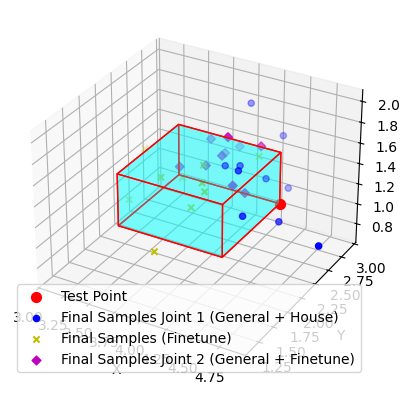

In [ ]:
# Ensure test_point is a 1D array with coordinates
test_point = test[33]
x, y, z = test_point
test_point = torch.tensor(test_point, device=device).view(1, 3, 1)

# generate samples
# World Model
final_samples_world, all_samples_world = sample_generate(model_world, nsamples=10, X=test_point, yfeatures=3)

# House Model
final_samples_house, all_samples_house = sample_generate(model_house, nsamples=10, X=test_point, yfeatures=3)

# Finetune Model
final_samples_finetune, all_samples_finetune = sample_generate(model_finetune, nsamples=10, X=test_point, yfeatures=3)

# Joint Model 1
final_samples_joint, all_samples_joint = sample_joint_generate(model_house, model_world, nsamples=10, X=test_point, yfeatures=3)

# Joint Model 2
final_samples_joint2, all_samples_joint2 = sample_joint_generate(model_finetune, model_world, nsamples=10, X=test_point, yfeatures=3)


# Plot
# creating 3d plot using matplotlib
# in python

# for creating a responsive plot
%matplotlib inline

from mpl_toolkits.mplot3d.art3d import Poly3DCollection
# Define function to plot range and generated samples
def plot_range(x, y, z, final_samples_joint, final_samples_joint2, final_samples_house, final_samples_world, final_samples_finetune):
    # Define the corners of the cuboid
    corners = np.array([
        [x-1, y-1, z], [x, y-1, z], [x, y, z], [x-1, y, z],
        [x-1, y-1, z+0.5], [x, y-1, z+0.5], [x, y, z+0.5], [x-1, y, z+0.5]
    ])

    # Define faces of the cuboid
    faces = [
        [corners[0], corners[1], corners[2], corners[3]],  # Bottom
        [corners[4], corners[5], corners[6], corners[7]],  # Top
        [corners[0], corners[1], corners[5], corners[4]],  # Front
        [corners[1], corners[2], corners[6], corners[5]],  # Right
        [corners[2], corners[3], corners[7], corners[6]],  # Back
        [corners[3], corners[0], corners[4], corners[7]]   # Left
    ]

    # Create a 3D figure
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot cuboid
    ax.add_collection3d(Poly3DCollection(faces, facecolors='cyan', linewidths=1, edgecolors='r', alpha=0.3))

    # Set labels and limits
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_xlim([x - 1.5, x + 0.5])
    ax.set_ylim([y - 1.5, y + 0.5])
    ax.set_zlim([z - 0.5, z + 1])

    # Plot test point
    ax.scatter(x, y, z, color='r', s=50, label='Test Point')

    # Helper function to plot samples
    def plot_samples(samples, color, label, marker):
        if samples is not None and len(samples) > 0:
            if isinstance(samples, torch.Tensor):
                samples = samples.cpu().numpy()
            samples = samples.reshape(-1, 3)
            ax.scatter(samples[:, 0], samples[:, 1], samples[:, 2], color=color, label=label, marker=marker)

    # Plot sample points
    plot_samples(final_samples_joint, 'b', 'Final Samples Joint 1 (General + House)', 'o')
    # plot_samples(final_samples_house, 'g', 'Final Samples (House)', '^')
    # plot_samples(final_samples_world, 'orange', 'Final Samples (World)', 's')
    plot_samples(final_samples_finetune, 'y', 'Final Samples (Finetune)', 'x')
    plot_samples(final_samples_joint2, 'm', 'Final Samples Joint 2 (General + Finetune)', 'D')
    # Show legend and plot
    plt.legend()
    plt.show()

# Call the function with test data
plot_range(x, y, z, final_samples_joint=final_samples_joint, final_samples_joint2=final_samples_joint2,
           final_samples_house=final_samples_house, final_samples_world=final_samples_world, final_samples_finetune=final_samples_finetune)


In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

Support for third party widgets will remain active for the duration of the session. To disable support:

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()